In [39]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math

In [40]:
DEFORMATION_METHODS = ["Random", "Mirror"]
OPTIMIZER_METHODS = ["Iterative", "Annealing"]
SMOOTHING_METHODS = ["Laplacian"]

In [41]:
def graph_json_annealing(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        name = json_data['ObjectName']
        seed = json_data['Seed']
        vertex_count = json_data['VertexCount']
        deformed_deviation = json_data['DeformedAngularDeviation']
        deformation_method = DEFORMATION_METHODS[json_data['DeformationMethod']]

        smoothened = json_data['Smoothened']
        smoothing_method = SMOOTHING_METHODS[json_data['SmoothingMethod']] if smoothened else "None"
        smoothing_strength = json_data['SmoothingStrength']

        optimizer_method = OPTIMIZER_METHODS[json_data['OptimizerMethod']]
        sampling_rate = json_data['SamplingRate']
        vertex_selection_method = json_data['VertexSelectionMethod']
        offsets = np.array(json_data['Offsets'], dtype='float')
        chosen_vertices = np.array(json_data['ChosenVertices'], dtype='int')
        ideal_normal_angles_from_ray = np.array(json_data['IdealNormalAnglesFromRay'], dtype='float')
        accepted_iterations = np.array(json_data['AcceptedIterations'], dtype='bool')
        optimized_deviations = np.array(json_data['OptimizedDeviations'], dtype='float')
        
        iterations = chosen_vertices.size
        current_deviations = np.array(json_data['CurrentDeviations'], dtype=float)
        smooth_angular_deviation = json_data['SmoothenedAngularDeviation']
        time_ms = json_data['TimeMilliseconds']
        temps = np.array(json_data['Temperatures'], dtype=float)

        final_deviation = optimized_deviations[-1]
        opt_deviation_diff_percent = (final_deviation - optimized_deviations[0]) / optimized_deviations[0] * 100
        smooth_deviation_diff_percent = (smooth_angular_deviation - final_deviation) / final_deviation * 100
        effective_iterations = np.sum(accepted_iterations)

        info = f"Plot of total angular deviation for {iterations} iterations\n"
        info += f"Object: {name}\n"
        info += f"Vertices: {vertex_count} (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)\n"
        if (deformation_method == "Random" or vertex_selection_method == "Random"):
            info += f"Seed {seed}\n"
        info += f"Deformation method: {deformation_method}\n"
        info += f"Optimizer method: {optimizer_method}\n"
        info += f"Vertex selection method: {vertex_selection_method}\n"
        info += f"Smoothing: {smoothing_method} (Strength: {smoothing_strength})\n"
        info += f"{effective_iterations} iterations of total amount ({np.round(effective_iterations/iterations*100, 2)}%) reduced the minimum\n"
        info += f"Time: {time_ms} ms\n"
        info += f"Total angular deviation reduced by optimization from {np.round(deformed_deviation, 2)} to {np.round(final_deviation, 2)} ({np.round(opt_deviation_diff_percent, 2)}%)\n"
        info += f"Total angular deviation changed by smoothing from {np.round(final_deviation, 2)} to {np.round(smooth_angular_deviation, 2)} ({np.round(smooth_deviation_diff_percent, 2)}%)\n"
        print(info)

        fig= plt.figure()
        lnsOpt = plt.plot(range(iterations), current_deviations, label='Optimized TADoN')
        if (smoothened):
            lnsSm = plt.plot([0, iterations-1], [smooth_angular_deviation, smooth_angular_deviation], label="Smoothened TADoN")

        plt.xlabel("Iterations")
        plt.ylabel("TADoN (degrees)")

        ax2 = plt.twinx()
        lnsTemp = ax2.plot(range(iterations), temps, color='red', label='Temperature')
        ax2.set_ylabel("Temperature")
        
        lns = lnsOpt
        if (smoothened):
            lns += lnsSm
        lns += lnsTemp
        labels = [l.get_label() for l in lns]
        plt.legend(lns, labels)
            
        fig.tight_layout()
        fig.show()

Plot of total angular deviation for 100000 iterations
Object: High Vertex Plane
Vertices: 961 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Seed 0
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
Smoothing: Laplacian (Strength: 1.0)
5903 iterations of total amount (5.9%) reduced the minimum
Time: 2089598 ms
Total angular deviation reduced by optimization from 9666.56 to 6767.47 (-30.03%)
Total angular deviation changed by smoothing from 6767.47 to 8428.99 (24.55%)



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_66561/4081997347.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


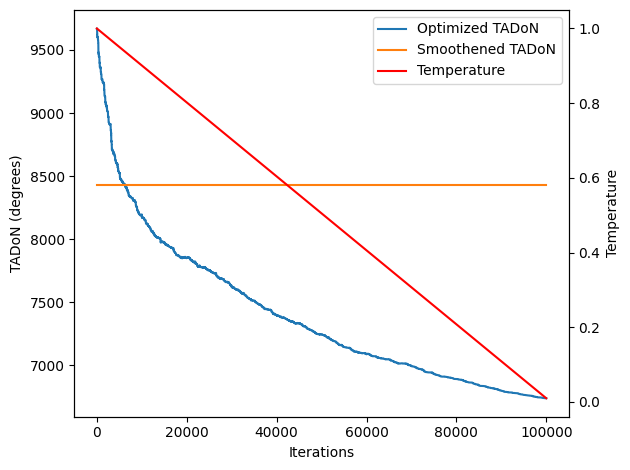

In [48]:
graph_json_annealing("High_Vertex_Plane_Mirror_100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_1.00.json")